# 1 - Risk and return models


<!-- In this section, we compare how well the different risk models predict an out-of-sample covariance matrix, and how well the different returns models predict out-of-sample returns. -->

이 섹션에서는 서로 다른 위험 모델이 표본 외 공분산 행렬을 얼마나 잘 예측하는지와 서로 다른 수익 모델이 표본 외 수익을 얼마나 잘 예측하는지 비교합니다.

## Risk models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
pypfopt.__version__

'1.2.7'

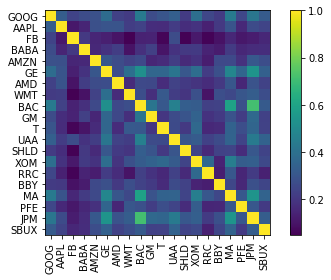

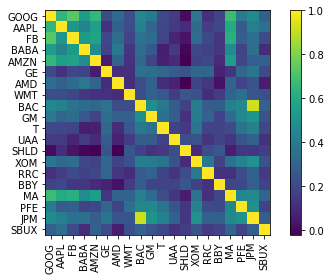

In [2]:
df = pd.read_csv("data/stock_prices.csv", parse_dates=True, index_col="date")
past_df, future_df = df.iloc[:-250], df.iloc[-250:]

future_cov = risk_models.sample_cov(future_df)
sample_cov = risk_models.sample_cov(past_df)

plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

<!-- We can see that visually, the sample covariance does not capture some of the new features of the covariance matrix, for example the highly correlated group of FAANG stocks. We may be able to improve this by using an exponentially-weighted covariance matrix, which gives more weight to recent data. We can also look at how each model predicts future variance.
 -->
시각적으로 샘플 공분산이 공분산 행렬의 일부 새로운 기능(예 : FAANG 주식의 상관 관계가 높은 그룹)을 캡처하지 않음을 알 수 있습니다. 최근 데이터에 더 많은 가중치를 부여하는 **지수 가중치 공분산 행렬**을 사용하여 이를 개선 할 수 있습니다. 또한 각 모델이 미래 분산을 어떻게 예측하는지 볼 수 있습니다.

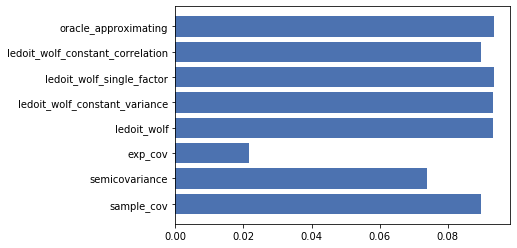

In [3]:
future_variance = np.diag(future_cov)
mean_abs_errors = []

risk_methods = [
    "sample_cov",
    "semicovariance",
    "exp_cov",
    "ledoit_wolf",
    "ledoit_wolf_constant_variance",
    "ledoit_wolf_single_factor",
    "ledoit_wolf_constant_correlation",
    "oracle_approximating",
]

for method in risk_methods:
    S = risk_models.risk_matrix(df, method=method)
    variance = np.diag(S)
    mean_abs_errors.append(np.sum(np.abs(variance - future_variance)) / len(variance))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, risk_methods)
plt.show()

<!-- We can see that the exponential covariance matrix is a much better estimator of future variance compared to the other models. Its mean absolute error is 2%, which is actually pretty good. Let's visually compare the exponential cov matrix to the realised future cov matrix: -->

지수 공분산 행렬이 다른 모델에 비해 미래 분산을 훨씬 더 잘 추정한다는 것을 알 수 있습니다. 평균 절대 오차는 2%로 실제로 꽤 좋습니다. 지수 cov 행렬을 실현된 미래 cov 행렬과 시각적으로 비교해 보겠습니다.

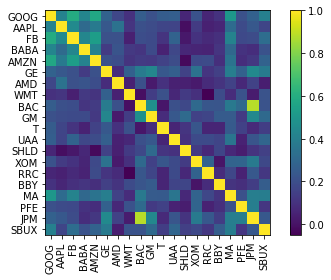

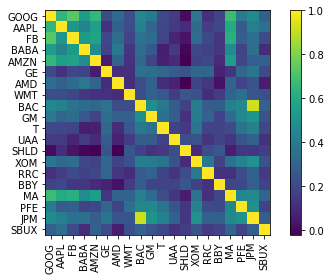

In [9]:
exp_cov = risk_models.exp_cov(past_df)

plotting.plot_covariance(exp_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)

plt.show()

## Returns

<!-- What about returns? Will the exponentially-weighted returns similarly be the best performer? -->
수익률은 어떻습니까? 기하 급수적으로 가중 된 수익률도 마찬가지로 최고의 성과를 거둘까요?

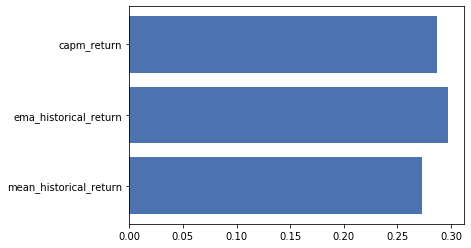

In [10]:
future_rets = expected_returns.mean_historical_return(future_df)
mean_abs_errors = []
return_methods = [
    "mean_historical_return",
    "ema_historical_return",
    "capm_return",
    ]

for method in return_methods:
    mu = expected_returns.return_model(past_df, method=method)
    mean_abs_errors.append(np.sum(np.abs(mu - future_rets)) / len(mu))
    
xrange = range(len(mean_abs_errors))
plt.barh(xrange, mean_abs_errors)
plt.yticks(xrange, return_methods)
plt.show()

<!-- The exponential moving average is marginally better than the others, but the improvement is almost unnoticeable. We also note that the mean absolute deviations are above 25%, meaning that if your expected annual returns are 10%, on average the realised annual return could be anywhere from a 15% loss to a 35% gain. This is a massive range, and gives some context to the advice in the docs suggesting that you optimise without providing an estimate of returns. -->

지수 이동 평균은 다른 것보다 약간 낫지만 개선은 거의 눈에 띄지 않습니다. 그 개선은 거의 눈에 띄지 않는다. 또한 평균 절대 편차가 25%를 초과한다는 것은 예상 연간 수익률이 10%일 경우 평균적으로 실현된 연간 수익률은 15%의 손실에서 35%의 증가까지 어느 곳이든 될 수 있다는 것을 의미한다. 이것은 엄청난 범위인데, 당신이 수익의 추정치를 제시하지 않고 최적화할 것을 제안하는 문서들의 조언에 약간의 맥락을 준다.

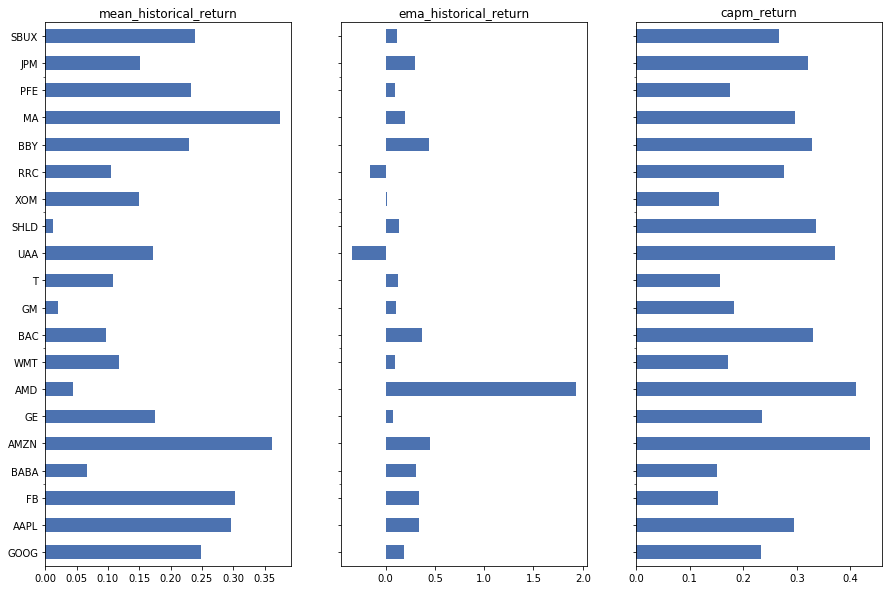

In [12]:
fig, axs = plt.subplots(1, len(return_methods), sharey=True, figsize=(15,10))

for i, method in enumerate(return_methods):
    mu = expected_returns.return_model(past_df, method=method)
    axs[i].set_title(method)
    mu.plot.barh(ax=axs[i])

<!-- The good news is that we see a good degree of agreement (apart from the `ema` method). -->
좋은 소식은 (`ema` 메서드와는 별개로) 어느 정도의 합의가 이루어진다는 것이다.